## SetUp

In [1]:
# preprocessing

# The only thing we do is band-pass filter between 1 and 50 Hz,
# and if the signal exceeds 150 μV on any channel, we consider it an artifact.

import mne
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
os.chdir('..')


# helpers
def flag_bad_channels(raw, l_freq=1., h_freq=50.,
                      var_z_thr=-3.0,         # flatness threshold (z-score)
                      psd_lo_thr=-3.0,        # very low broadband PSD (z-score)
                      beta_hi_thr=3.0,        # high beta/gamma outlier (z-score)
                      beta_band=(15, 40),
                      broad_band=(1, 45),
                      picks="eeg"):
    """Return list of bad channel names based on amplitude + PSD outliers."""
    raw_f = raw.copy().filter(l_freq, h_freq, picks=picks, verbose=False)

    # --- 1) Flat / dead channels via variance ---
    data = raw_f.get_data(picks=picks)
    ch_vars = np.var(data, axis=1)
    var_z = (np.log(ch_vars) - np.mean(np.log(ch_vars))) / np.std(np.log(ch_vars))
    bad_var = np.array(raw_f.ch_names)[var_z < var_z_thr]

    # --- 2) PSD-based broadband low-power channels ---
    psd, freqs = mne.time_frequency.psd_array_welch(
        data, sfreq=512, fmin=broad_band[0], fmax=broad_band[1],
        n_fft=2048, verbose=False
    )
    broad_pow = psd.mean(axis=1)
    broad_z = (np.log(broad_pow) - np.mean(np.log(broad_pow))) / np.std(np.log(broad_pow))
    bad_broad = np.array(raw_f.ch_names)[broad_z < psd_lo_thr]

    # --- 3) High beta/gamma outliers (EMG / bad contact) ---
    psd_beta, freqs_beta = mne.time_frequency.psd_array_welch(
        data, sfreq=512, fmin=beta_band[0], fmax=beta_band[1],
        n_fft=2048, verbose=False
    )
    beta_pow = psd_beta.mean(axis=1)
    beta_z = (np.log(beta_pow) - np.mean(np.log(beta_pow))) / np.std(np.log(beta_pow))
    bad_beta = np.array(raw_f.ch_names)[beta_z > beta_hi_thr]

    bads = sorted(set(bad_var) | set(bad_broad) | set(bad_beta))

    report = {
        "bad_var": list(bad_var),
        "bad_broad_low": list(bad_broad),
        "bad_beta_high": list(bad_beta),
        "var_z": dict(zip(raw_f.ch_names, var_z)),
        "broad_z": dict(zip(raw_f.ch_names, broad_z)),
        "beta_z": dict(zip(raw_f.ch_names, beta_z)),
    }
    return bads, report

def flag_bad_neighbors(raw, picks="eeg", corr_z_thr=-2.5):
    """Flag channels whose average correlation with neighbors is abnormally low."""
    # find sensor adjacency (from montage)
    adjacency, ch_names = mne.channels.find_ch_adjacency(raw.info, ch_type='eeg')
    adjacency = adjacency.toarray()

    data = raw.get_data(picks=picks)
    corr = np.corrcoef(data)

    avg_neighbor_corr = []
    for i, ch in enumerate(ch_names):
        neighbors = np.where(adjacency[i] == 1)[0]
        if len(neighbors) == 0:
            avg_neighbor_corr.append(np.nan)
            continue
        avg_neighbor_corr.append(np.mean(corr[i, neighbors]))

    avg_neighbor_corr = np.array(avg_neighbor_corr, dtype=float)
    z = (avg_neighbor_corr - np.nanmean(avg_neighbor_corr)) / np.nanstd(avg_neighbor_corr)

    bad_corr = np.array(ch_names)[z < corr_z_thr]
    return bad_corr, dict(zip(ch_names, z))


def flag_hf_noisy(raw, hf_band=(30, 50), lf_band=(1, 30),
                  hf_ratio_z_thr=3.0, picks="eeg"):
    raw_f = raw.copy().filter(1., 50., picks=picks, verbose=False)
    data = raw.get_data(picks=picks)

    psd, freqs = mne.time_frequency.psd_array_welch(
        data, 512, fmin=1, fmax=50, n_fft=2048, verbose=False
    )

    hf = psd[:, (freqs >= hf_band[0]) & (freqs <= hf_band[1])].mean(axis=1)
    lf = psd[:, (freqs >= lf_band[0]) & (freqs <= lf_band[1])].mean(axis=1)

    ratio = np.log(hf / lf)
    z = (ratio - ratio.mean()) / ratio.std()

    bad_hf = np.array(raw_f.ch_names)[z > hf_ratio_z_thr]
    return bad_hf, dict(zip(raw_f.ch_names, z))


def flag_drift_jumps(raw, picks="eeg",
                     drift_z_thr=3.0,
                     jump_z_thr=3.0,
                     hp=0.5):
    """
    Detect electrodes with non-physiological drifts and fast baseline jumps.
    """
    sfreq = raw.info['sfreq']

    # High-pass lightly to isolate drifts (slow stuff <0.5 Hz)
    raw_lp = raw.copy().filter(None, hp, picks=picks, verbose=False)
    raw_hp = raw.copy().filter(hp, None, picks=picks, verbose=False)

    data_lp = raw_lp.get_data(picks=picks)   # slow drifts
    data_hp = raw_hp.get_data(picks=picks)   # jumps/edges

    # Drift metric = std of <0.5 Hz component
    drift_std = data_lp.std(axis=1)
    drift_z = (drift_std - drift_std.mean()) / drift_std.std()

    # Jump metric = median absolute derivative of >0.5 Hz component
    deriv = np.abs(np.diff(data_hp, axis=1))
    jump_med = np.median(deriv, axis=1)
    jump_z = (jump_med - jump_med.mean()) / jump_med.std()

    chs = raw_lp.ch_names
    bad_drift = np.array(chs)[drift_z > drift_z_thr]
    bad_jump  = np.array(chs)[jump_z > jump_z_thr]

    bads = sorted(set(bad_drift) | set(bad_jump))

    return bads, {
        "drift_z": dict(zip(chs, drift_z)),
        "jump_z": dict(zip(chs, jump_z)),
        "bad_drift": list(bad_drift),
        "bad_jump": list(bad_jump),
    }

def correct_bad_names(bads):
    return [str(i) for i in bads]

## Detect bad channels

In [9]:
import os
os.getcwd()
os.chdir('/Users/yeganeh/Codes/MovieEEG-SourcePipeline/')

In [10]:
# bad_channels = pd.DataFrame(index=range(1, 33), columns=['art_nl', 'art_l', 'city_nl', 'city_l'])
bad_channels = pd.read_csv('data/bad_channels.csv', index_col=0)

### open data

In [ ]:
sub_id = '01'
movie = 'art'
order = 'nl'
movie_order = movie + '_' + order
file_name = f'{sub_id}_{movie_order}'
eeg_path = f'data/eeg/{movie}_edf/{movie_order}/{file_name}.edf'
raw = mne.io.read_raw_edf(eeg_path, preload=True)
raw.drop_channels(['Status'])

mon = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(mon)

bad_var, rep = flag_bad_channels(raw)
bad_corr, corr_z = flag_bad_neighbors(raw)
bad_hf, hf_z = flag_hf_noisy(raw)
bad_drift, rep4 = flag_drift_jumps(raw)

bad_var = correct_bad_names(bad_var)
bad_corr = correct_bad_names(bad_corr)
bad_hf = correct_bad_names(bad_hf)
bad_drift = correct_bad_names(bad_drift)

# FRONTAL_EXEMPT = ["Fp1","Fp2","AF7","AF8","AF3","AF4"]
# bad_drift = [ch for ch in bad_drift if ch not in FRONTAL_EXEMPT]

bads = sorted(set(bad_var) |
              set(bad_corr) |
              set(bad_hf) |
              set(bad_drift))

print("Auto-flagged bads:", bads)
print("Why:")
print("  flat/low-var:", rep["bad_var"])
print("  broadband-too-low:", rep["bad_broad_low"])
print("  beta/gamma-too-high:", rep["bad_beta_high"])
print("  Neighbor-correlation bads:", bad_corr)
print("  HF-noisy bads:", bad_hf)
print("  slow drifts & jumps:", bad_drift)

# raw.info["bads"] = bads
# raw.interpolate_bads(reset_bads=False)

In [86]:
# raw.notch_filter([50, 100])
# sus_ch = 'T8'
for sus_ch in bads:

    data = raw.get_data(picks="eeg")
    var = np.var(data, axis=1)
    z_var = (var - var.mean()) / var.std()

    vars = dict(zip(raw.ch_names, z_var))
    corr = np.corrcoef(data)
    idx = raw.ch_names.index(sus_ch)
    mean_corr = np.mean(np.delete(corr[idx], idx))

    psds, freqs = mne.time_frequency.psd_array_welch(
        raw.get_data(), sfreq=512, fmin=20, fmax=40, verbose=False
    )
    hf_power = psds.mean(axis=1)
    z_hf = (hf_power - hf_power.mean()) / hf_power.std()

    print(sus_ch, vars[sus_ch], mean_corr, dict(zip(raw.ch_names, z_hf))[sus_ch])

CP6 3.223365246274323 0.12335612772811427 0.3181792508594596
F8 0.013205970313715985 0.25370441512478575 1.9794334158581661
O1 3.525289659706718 0.10775458316249092 1.4793761843075177


### Visually inspect bad channels

In [ ]:
# Frequency domian
raw.copy().pick_channels(set(bads)).plot_psd(fmax=60, spatial_colors=True, show=False, n_fft=8192)
plt.show()

raw.copy().plot_psd(fmax=60, spatial_colors=True, show=False)
plt.show()

In [ ]:
# time domian
raw.copy().notch_filter([50, 100]).plot(n_channels=33, remove_dc=True, lowpass=50, highpass=1) # 

In [ ]:
# add detected bad channels to the list
bad_channels.loc[int(sub_id), movie_order] = bads

In [128]:
import re
re.findall(r"'([^']+)'", bad_channels.loc[14, 'art_nl'])

['P7', 'T8']

Channels marked as bad:
none


## Prpeprocess
### 1. open data

In [19]:
# open raw
sub_id = '03'
movie = 'art'
order = 'nl'
movie_order = movie + '_' + order
file_name = f'{sub_id}_{movie_order}'
eeg_path = f'data/eeg/{movie}_edf/{movie_order}/{file_name}.edf'

raw = mne.io.read_raw_edf(eeg_path, preload=True)
mon = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(mon)

# open bad channels
bad_channels = pd.read_csv('data/bad_channels.csv', index_col=0)


# crop offset
offset = pd.read_csv('data/film_start.csv')
idx = file_name + '.bdf'
sub_offset = offset.set_index('file').loc[idx, 'film_start']

# sanity check before cutting the offset 
status_ch_events = mne.find_events(raw, stim_channel="Status")

if status_ch_events[1, 0] == sub_offset * raw.info['sfreq']:  # the timing of the second event in the satus channel should corresponds to the movie start (where we cut the data)
    print('The offset is compatible with Status channel')
    raw.crop(tmin=sub_offset)
else:
    print('!!!The offset is NOT compatible with Status channel... DID NOT CROP!!!')

Extracting EDF parameters from /Users/yeganeh/Codes/MovieEEG-SourcePipeline/data/eeg/art_edf/art_nl/03_art_nl.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 334335  =      0.000 ...   652.998 secs...
Finding events on: Status
170 events found on stim channel Status
Event IDs: [  1   2   3   4   5   6   7   8  12  13  14  23  24  25  34 123 124 234]
The offset is compatible with Status channel


### 2. Interpolate Bads

In [3]:
bads = bad_channels.loc[int(sub_id), movie_order]
if not np.isnan(bads):
    print('bad channels detected')
    raw.info['bads'] = bads
    raw.interpolate_bads()

### 3. Band pass Filter (1-50)

In [ ]:
raw.filter(l_freq=1, h_freq=50, picks="eeg")

# can replace this with other approaches
raw.notch_filter([50, 100])

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 1691 samples (3.303 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)



<RawEDF | 03_art_nl.edf, 33 x 328954 (642.5 s), ~82.9 MiB, data loaded>

### 4. ICA

In [ ]:
# Vertical EOG proxy: Fp1 - Cz
raw = mne.set_bipolar_reference(raw, "Fp1", "Cz", ch_name="VEOG", drop_refs=False)
raw.set_channel_types({"VEOG": "eog"})

# Horizontal EOG proxy (optional): F7 - F8
raw = mne.set_bipolar_reference(raw, "F7", "F8", ch_name="HEOG", drop_refs=False)
raw.set_channel_types({"HEOG": "eog"})

raw_filt = raw.copy().filter(1., 40., picks=["eeg", "eog"])

ica = mne.preprocessing.ICA(n_components=0.99, method="fastica", random_state=97)
ica.fit(raw_filt)

eog_inds_v, scores_v = ica.find_bads_eog(raw_filt, ch_name="VEOG")
eog_inds_h, scores_h = ica.find_bads_eog(raw_filt, ch_name="HEOG")

eog_inds_v = [i for i in eog_inds_v if abs(scores_v[i]) >= 0.5]
eog_inds_h = [i for i in eog_inds_h if abs(scores_h[i]) >= 0.5]

bad_ic = sorted(set(eog_inds_v + eog_inds_h))
ica.exclude = bad_ic

raw_ica = ica.apply(raw.copy())


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=328954
    Range : 5382 ... 334335 =     10.512 ...   652.998 secs
Ready.
Added the following bipolar channels:
VEOG
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=328954
    Range : 5382 ... 334335 =     10.512 ...   652.998 secs
Ready.
Added the following bipolar channels:
HEOG
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 

In [28]:
raw.get_data().shape[1] / raw.info['sfreq']  # duration in seconds

642.48828125

In [ ]:
# ICA report
report = mne.Report(title=f"ICA report – {file_name}")

report.add_ica(
    ica=ica,
    title="ICA components",
    inst=raw_filt,
    picks=ica.exclude if ica.exclude else None,
    n_jobs=1
)

report.add_figure(
    ica.plot_components(show=False),
    title="All IC topographies"
)

report.add_figure(
    ica.plot_sources(raw_filt, show=False),
    title="IC time courses"
)

# add table and a bar plot of scores to the report
df_scores = pd.DataFrame({
    "IC": np.arange(ica.n_components_),
    "EOG_V_score": scores_v,
    "EOG_H_score": scores_h
})

html = df_scores.to_html(index=False, float_format="%.3f")

report.add_html(
    html,
    title="ICA EOG correlation scores"
)

fig, ax = plt.subplots(figsize=(6, 3))
ax.bar(df_scores["IC"], df_scores["EOG_V_score"], label="VEOG")
ax.bar(df_scores["IC"], df_scores["EOG_H_score"], alpha=0.6, label="HEOG")
ax.axhline(0.5, color="r", linestyle="--", linewidth=1)
ax.axhline(-0.5, color="r", linestyle="--", linewidth=1)
ax.set_xlabel("IC")
ax.set_ylabel("Correlation")
ax.legend()
report.add_figure(fig, title="EOG–IC correlation scores")

report.save(f"data/reports/{file_name}_ica_report.html", overwrite=True)

### 5. Epoch data and reject bad segments

Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 615 original time points ...
1 bad epochs dropped


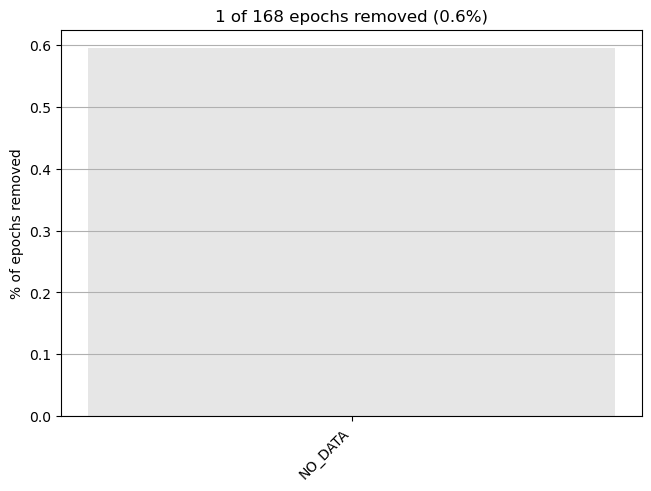

In [ ]:
# TODO: move this chuch to open data
cuts_art_l = pd.read_csv('data/Art_l_all_cuts.csv')  # epoch the data based on the cuts
cuts_art_l = cuts_art_l[cuts_art_l['Time'] >= 0]  # Drop sentinel (-1), keep real cuts (including 0)

events = []
for _, row in cuts_art_l.iterrows():
    sample = row['Time']
    events.append([int(sample * raw.info['sfreq']+ raw.first_samp), 0, 1])  # first sample is in fact equal to sub_offset * sampling_rate
events = np.array(events, dtype=int)

reject = dict(eeg=150e-6)  # 150 µV in Volts
epochs_clean = mne.Epochs(raw_ica,
                    events,
                    event_id={'cuts': 1},
                    tmin=-0.2,
                    tmax=1,
                    baseline=None, # no baseline correction
                    preload=True,
                    reject=reject,
                    reject_by_annotation=True)

epochs_clean.plot_drop_log()
plt.show()
drop_log = epochs_clean.drop_log